<a href="https://colab.research.google.com/github/CSID-DGU/2021-1-CECD3-SASO-2/blob/master/NLP/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NLP 분석

0. Colab에 라이브러리 설치

In [ ]:
# !pip install pykospacing
# !pip install konlpy


# #Google drive 
# drive.mount('/content/drive')

#한글 폰트 
!apt -qq -y install fonts-nanum > /dev/null
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

1. 라이브러리 로딩


In [ ]:
import re
import os
import sys
import json
import pandas as pd
import numpy as np

from google.colab import drive
# from pykospacing import spacing
from konlpy.tag import Kkma
from konlpy.tag import Okt
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# import soynlp
import nltk

kkma = Kkma()
okt = Okt()
plt.rc('font', family='NanumBarunGothic') 

2.전처리 과정

In [ ]:
#파일 경로
review_path = '/content/drive/MyDrive/Colab Notebooks/nlp/review.txt'


#pandas 로 불러온다
review_df = pd.read_csv(review_path, '\t')

# #리뷰가 널인 경우 , '' 값으로 대체
# review_df.isnull().any() #document에 null값이 있다.
# review_df['document'] = review_df['document'].fillna(''); #null값을 ''값으로 대체


#review list 로 변환
newData = []
for i in tqdm(range(len(review_df))):
  newData.append(review_df.values[i])

#tokenize 함수
def tokenize(doc):
  #형태소와 품사를 join
  return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]


# tokenize 과정
new_docs = [(tokenize(row[0])) for row in tqdm(newData)]

print(newData)





[array(['비중격으로 수술했고 자연스럽게 해달라구 요청드렸는데 부목을 떼고 보니 생각보다 너무 화려한 코가 등장 했어요. 근데그 코가 저한테 너무 잘어울리더라구요. 코하나로 얼굴도 엄청 작아보이고 너무 좋았어요.여러 후기 사진을 봤지만 귀락쌤 디자인은 진짜 최고인 것 같아요.'],
      dtype=object), array(['브라운 김태규 원장님께 윤곽2종수술을 받았습니다. 수술 들어가기전 선생님이 뾰족라인 둥근라인 고르라 해서 둥근라인으로 골랐는데 둥근 라인으로 하길 정말 잘한 것 같아요!사람들도 얼굴이 정말 작아졌는데 살뺐냐 물어보는데라인이 둥글고 정말 자연스럽게 돼…'],
      dtype=object), array(['구축이나 별다른 부작용 낌새는 안 보이는데 지금 실리콘이 6mm나 들어가 있었는데이 높이감은 저랑 왜 안 어울릴 수밖에 없는지, 제 얼굴 이미지와 어울리는 라인은 없었어요'],
      dtype=object), array(['윤곽상담으로 받았고요~ 김태규원장님께 상담 받았어요~병원 상담 만 다녀본지 거의 한 세달은 된거같아요 흐지부지 끝나기도 했고 수술하지말까 생각도 할정도로 많이 지쳐있다보니까 제가 진짜 대충 이야기도 했고 대충 그냥 하면하고 말면 말고 이런식으로 이야기도 했는데 잘 받아주시고.. 걱정되시는 마음도 있으실거고 밍숭맹숭하실텐데 걱정마시라고 이야기도 잘 해주셨네요 ^^ 잘받고갑니다 감사해요~'],
      dtype=object), array(['윤곽 상담이라서 진짜 긴장하고 갔었는데.. 김태규 원장님으로 상담 했구요 뵙고 한 5분 얘기 나눴나 엄청 편해졌어요 ㅋㅋㅋㅋㅋㅋ 생각보다 안 딱딱하게? 상담 봐주셨고 말씀하실 때  수술때는 좀 딱딱하게 들어갈거다, 뼈를 깎는게 쉬운일은 아니니.. 하시더라구요 일부로 상담 때 조금 풀어지게 해주시는것 같더라구요 긴장하면 될것도 안된다 라는 식으로도 말씀해주시고 맘 편하게 하시는게 좋다고 하셨구요! 무튼 상담은 잘 끝냈습니다 ㅎ!'],
      dtype=obj

토큰개수: 2132
2132
715
[('하다/Verb', 97), ('상담/Noun', 68), ('./Punctuation', 45), ('이/Josa', 45), ('도/Josa', 35), ('님/Suffix', 35), ('은/Josa', 31), ('원장/Noun', 28), ('으로/Josa', 26), ('수술/Noun', 26)]


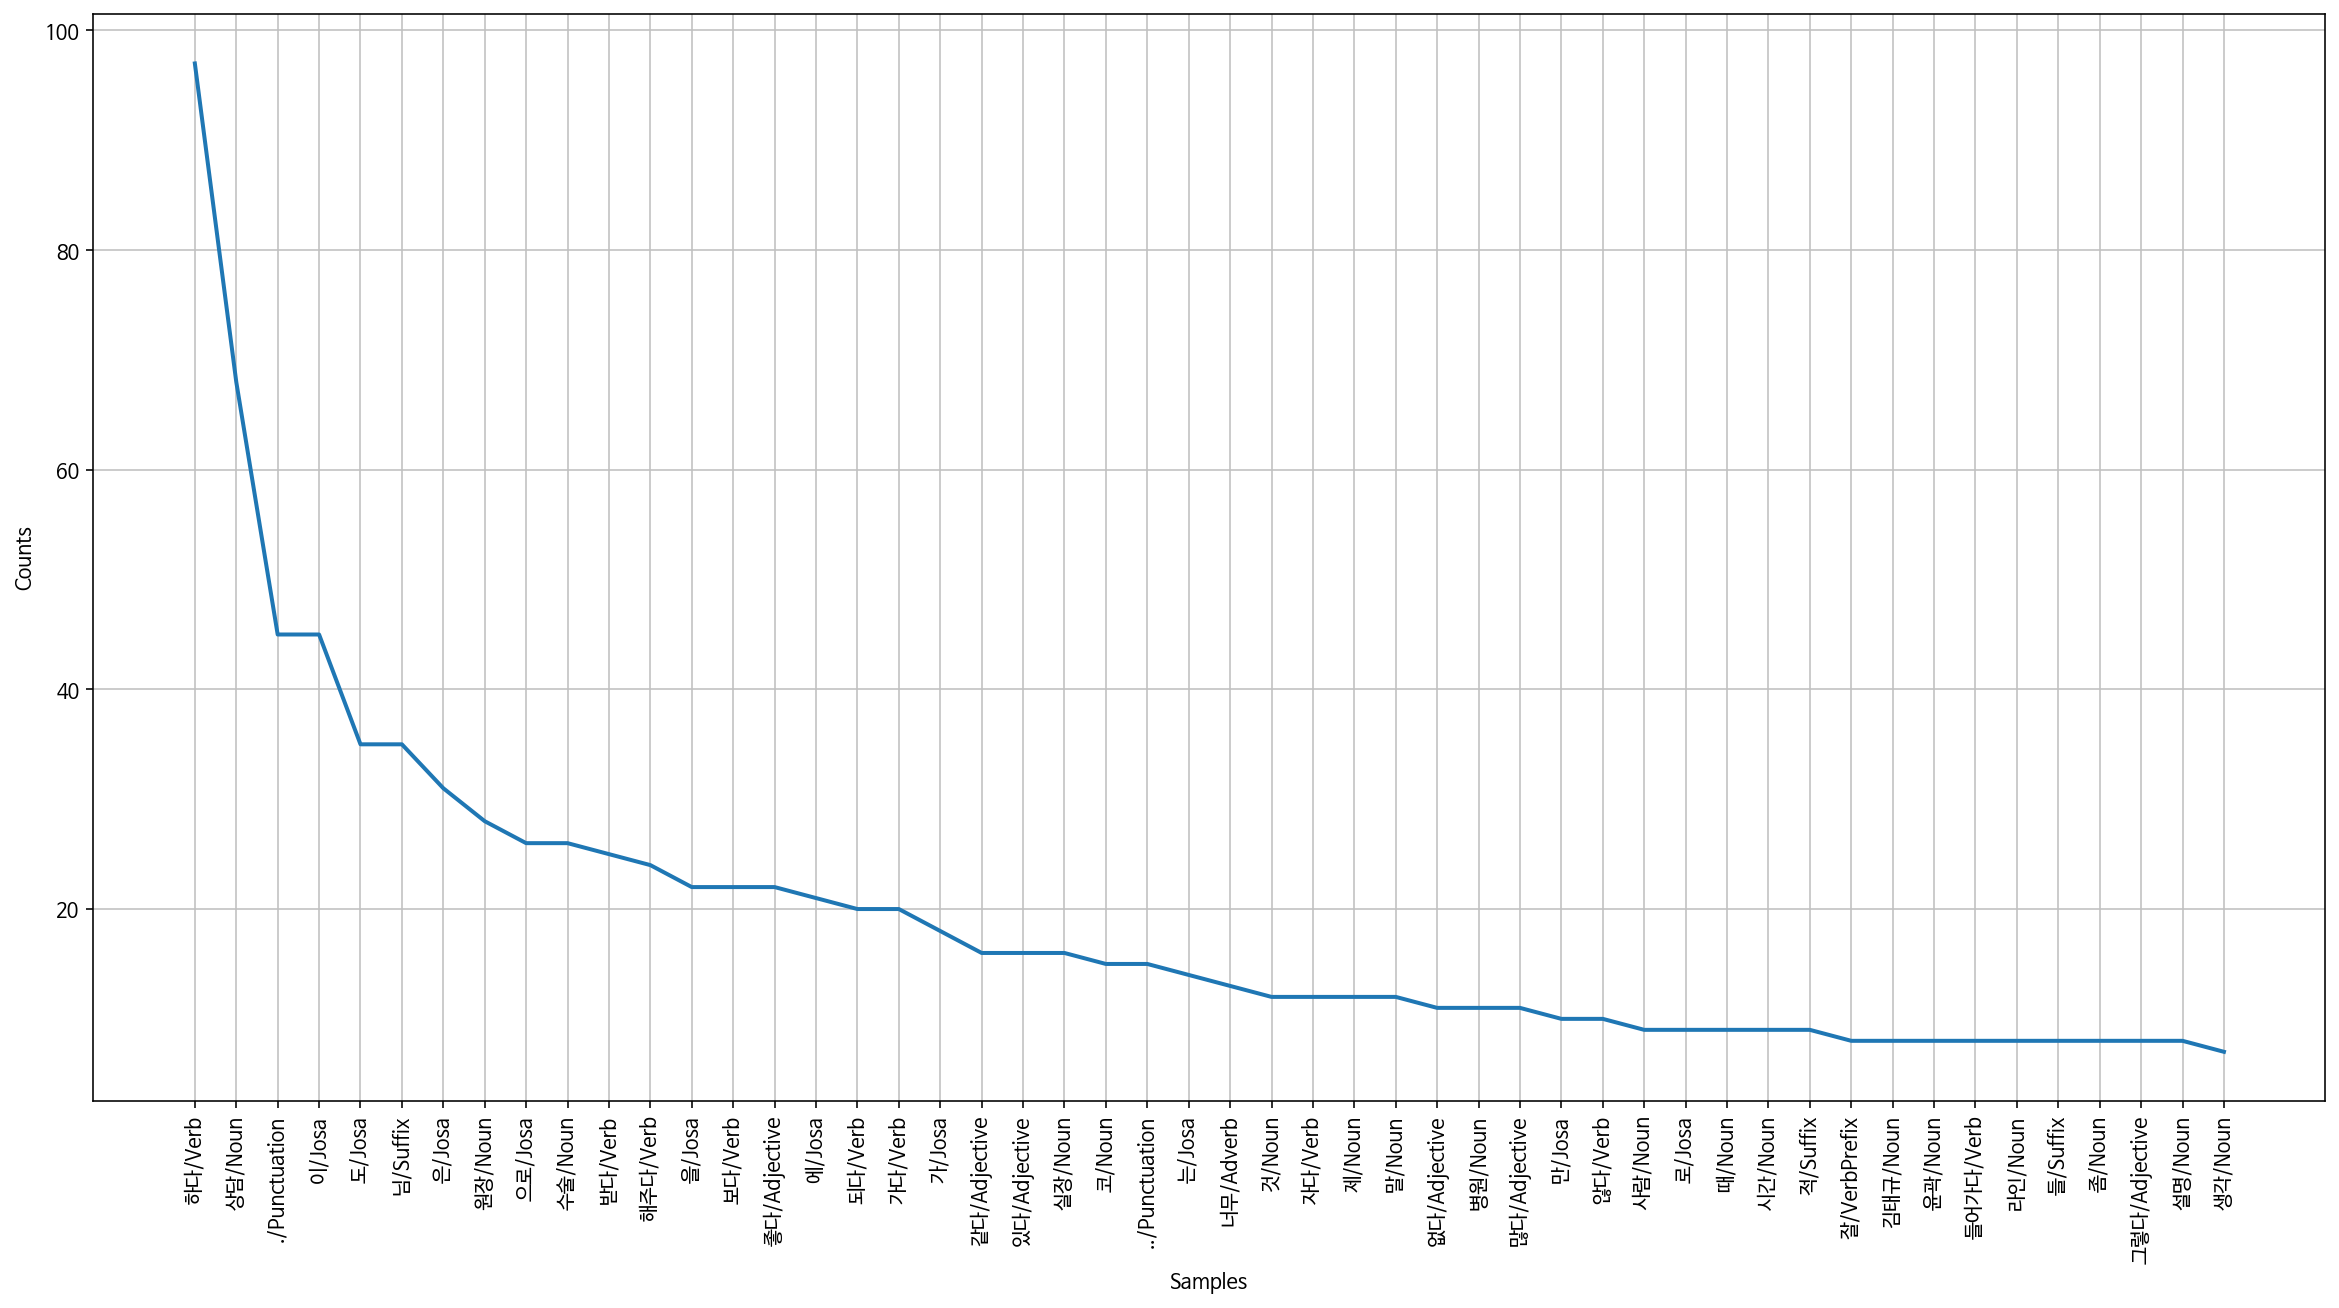

In [ ]:
#토큰 구하기
tokens = [t for d in new_docs for t in d]
print("토큰개수:", len(tokens))
# print(tokens)

#nltk 를 통한 전처리
text = nltk.Text(tokens, name='NMSC')

#토큰개수
print(len(text.tokens))

#중복을 제외한 토큰개수
print(len(set(text.tokens)))

#출력빈도가 높은 상위 토큰 10개
print(text.vocab().most_common(10))

#상위 토큰 10개 matpolib 으로 출력
plt.figure(figsize=(20,10))
text.plot(50)
